#Style Transfer Re-Producing

###1. 기본 라이브러리 및 설정

- 쿠다 사용

- 해상도 512 사용

- 이미지 전처리 : 크기 조정 및 텐서 변환

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import copy, os, random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("./results", exist_ok=True)

imsize = 512

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

##2. 이미지 로드 및 시각화 함수

In [ ]:
def image_loader(image_path):
    image = Image.open(image_path).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

##3. 모델 구성 요소 - ContentLoss, Gram matrix, StyleLoss

In [ ]:
def gram_matrix(input_tensor):
    a, b, c, d = input_tensor.size()
    features = input_tensor.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = 0

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = 0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

##4. VGG 기반 스타일 전이 모델

- pretrained VGG19 사용

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=['conv_4'],
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)

    normalization = transforms.Normalize(normalization_mean, normalization_std)
    model = nn.Sequential(normalization)

    content_losses = []
    style_losses = []
    i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break
    model = model[:(j+1)]

    return model, style_losses, content_losses

cnn = models.vgg19(pretrained=True).features.to(device).eval()
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

##5. 스타일 전이 함수

- 더 나은 결과를 위해 반복 횟수 증가

- 콘텐츠 이미지에 약간의 노이즈 추가하여 초기화함

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1e5, content_weight=1,
                       content_layers=['conv_4'],
                       style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    print("스타일 전이 시작...")
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img,
        content_layers=content_layers, style_layers=style_layers)

    input_img.requires_grad_(True)
    optimizer = optim.LBFGS([input_img])

    run = [0]
    while run[0] <= num_steps:
        def closure():
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_weight * style_score + content_weight * content_score
            loss.backward()

            if run[0] % 50 == 0:
                print(f"Step {run[0]}: 스타일 손실 {style_score.item():.4f}, 콘텐츠 손실 {content_score.item():.4f}")
            run[0] += 1
            return loss

        optimizer.step(closure)

    return input_img.detach()

##6. 데이터 랜덤 선택 함수

- 결과의 다양성을 보기 위해 실행할 때 마다 랜덤한 데이터 불러오도록 함

In [ ]:
def get_random_content_image(content_dir="./dataset/content"):
    files = [f for f in os.listdir(content_dir) if f.lower().endswith('.png')]
    if not files:
        raise FileNotFoundError("Content 폴더에 PNG 이미지가 없습니다.")
    chosen = random.choice(files)
    return os.path.join(content_dir, chosen)

def get_random_style_image(style_dir="./dataset/style"):
    subdirs = [d for d in os.listdir(style_dir) if os.path.isdir(os.path.join(style_dir, d))]
    if not subdirs:
        raise FileNotFoundError("Style 폴더 내에 서브 폴더가 없습니다.")
    chosen_subdir = random.choice(subdirs)
    full_subdir = os.path.join(style_dir, chosen_subdir)
    files = [f for f in os.listdir(full_subdir) if f.lower().endswith('.jpg')]
    if not files:
        raise FileNotFoundError(f"Style 폴더 '{chosen_subdir}'에 jpg 이미지가 없습니다.")
    chosen_file = random.choice(files)
    return os.path.join(full_subdir, chosen_file)


##7. 모델 실행 및 결과

- 3개의 페어로 실행함




=== Experiment 1 ===
Content image: ./dataset/content/A honey jar and an orange.png
Style image: ./dataset/style/Fauvism/03.jpg
스타일 전이 시작...
Step 0: 스타일 손실 0.0120, 콘텐츠 손실 11.5887
Step 50: 스타일 손실 0.0002, 콘텐츠 손실 17.9839
Step 100: 스타일 손실 0.0001, 콘텐츠 손실 19.2127
Step 150: 스타일 손실 0.0000, 콘텐츠 손실 18.7605
Step 200: 스타일 손실 0.0000, 콘텐츠 손실 17.0722
Step 250: 스타일 손실 0.0000, 콘텐츠 손실 15.2911
Step 300: 스타일 손실 0.0000, 콘텐츠 손실 14.0108
Step 350: 스타일 손실 0.0000, 콘텐츠 손실 13.1969
Step 400: 스타일 손실 0.0000, 콘텐츠 손실 12.6178
Step 450: 스타일 손실 0.0000, 콘텐츠 손실 12.1958
Step 500: 스타일 손실 0.0000, 콘텐츠 손실 11.8847


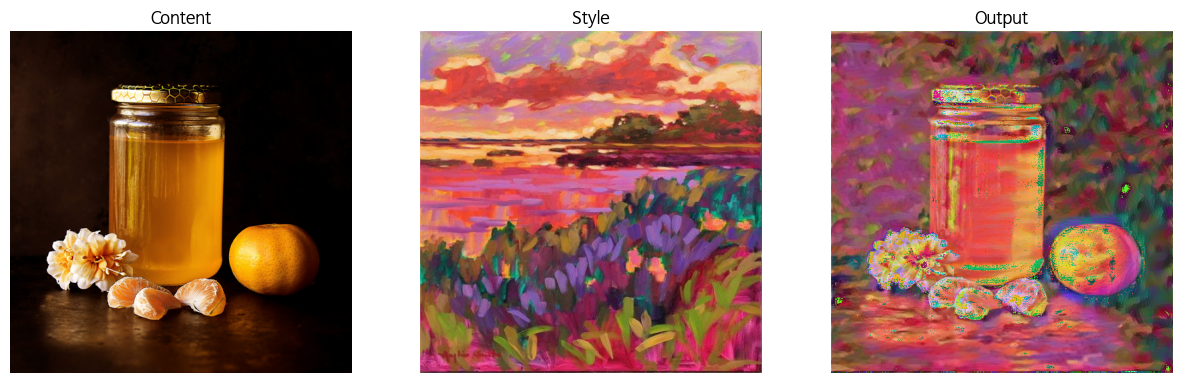


=== Experiment 2 ===
Content image: ./dataset/content/objects including a wine bottle, a wine glass, a bowl, a decorative bottle, and a sphere.png
Style image: ./dataset/style/Smoke & Light/04.jpg
스타일 전이 시작...
Step 0: 스타일 손실 0.0120, 콘텐츠 손실 12.0216
Step 50: 스타일 손실 0.0006, 콘텐츠 손실 8.8794
Step 100: 스타일 손실 0.0005, 콘텐츠 손실 8.7164
Step 150: 스타일 손실 0.0003, 콘텐츠 손실 9.2639
Step 200: 스타일 손실 0.0003, 콘텐츠 손실 9.4344
Step 250: 스타일 손실 0.0002, 콘텐츠 손실 9.4569
Step 300: 스타일 손실 0.0002, 콘텐츠 손실 9.4505
Step 350: 스타일 손실 0.0002, 콘텐츠 손실 9.4167
Step 400: 스타일 손실 0.0001, 콘텐츠 손실 9.4031
Step 450: 스타일 손실 0.0001, 콘텐츠 손실 9.4024
Step 500: 스타일 손실 0.0001, 콘텐츠 손실 9.4061


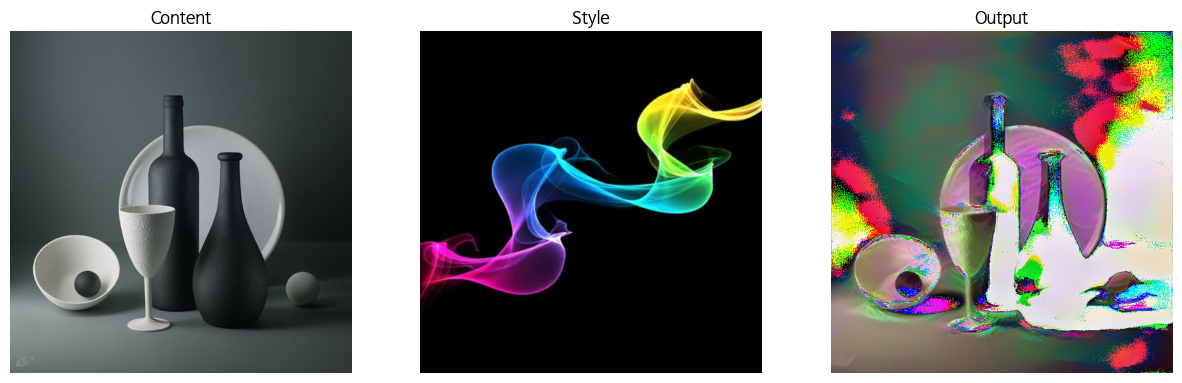


=== Experiment 3 ===
Content image: ./dataset/content/Towering mountains.png
Style image: ./dataset/style/Realism/04.jpg
스타일 전이 시작...
Step 0: 스타일 손실 0.0126, 콘텐츠 손실 8.8394
Step 50: 스타일 손실 0.0001, 콘텐츠 손실 23.1941
Step 100: 스타일 손실 0.0000, 콘텐츠 손실 22.4646
Step 150: 스타일 손실 0.0000, 콘텐츠 손실 20.0656
Step 200: 스타일 손실 0.0000, 콘텐츠 손실 17.3439
Step 250: 스타일 손실 0.0000, 콘텐츠 손실 15.3983
Step 300: 스타일 손실 0.0000, 콘텐츠 손실 13.9994
Step 350: 스타일 손실 0.0000, 콘텐츠 손실 13.0400
Step 400: 스타일 손실 0.0000, 콘텐츠 손실 12.4106
Step 450: 스타일 손실 0.0000, 콘텐츠 손실 11.9377
Step 500: 스타일 손실 0.0000, 콘텐츠 손실 11.6045


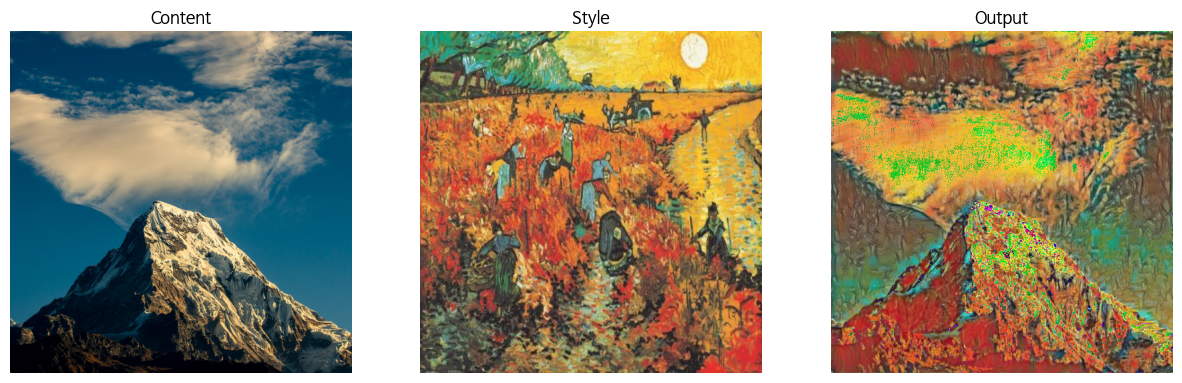

In [ ]:
num_experiments = 3
for i in range(1, num_experiments+1):
    print(f"\n=== Experiment {i} ===")
    content_path = get_random_content_image()
    style_path = get_random_style_image()
    print("Content image:", content_path)
    print("Style image:", style_path)

    content_img = image_loader(content_path)
    style_img = image_loader(style_path)

    noise = torch.randn(content_img.data.size(), device=device) * 0.05
    input_img = content_img + noise
    input_img.clamp_(0, 1)

    output = run_style_transfer(cnn, normalization_mean, normalization_std,
                                content_img, style_img, input_img,
                                num_steps=500, style_weight=1e6, content_weight=1)

    output_path = f"./results/result_{i}.jpg"
    output_image = output.cpu().clone().squeeze(0)
    output_image = transforms.ToPILImage()(output_image)
    output_image.save(output_path)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    imshow(content_img, title="Content")
    plt.subplot(1,3,2)
    imshow(style_img, title="Style")
    plt.subplot(1,3,3)
    imshow(output, title="Output")
    plt.show()

##어려웠던 점

- 콘텐츠와 스타일의 가중치 비율을 맞추지 않으니 한쪽에서만 손실이 줄어들어서 적절한 비율을 찾는데 시간이 걸렸다.

- 스타일에 충분한 정보가 있지 않은 경우 결과물이 이상했다.

##분석 및 고찰

- VGG19를 이용해서 스타일은 낮은 층을 콘텐츠는 높은 층을 사용하고자 register_forward_hook()을 사용했음

- 콘텐츠와 스타일 가중치 비율 조정이 아주 중요함

- 콘텐츠 이미지는 직선 형태의 피쳐가 많은 이미지, 스타일은 부드러운 느낌일수록 결과물이 잘 나왔음

- 현재는 스타일 이미지를 바꿀때마다 새로 학습해야해서 실시간 변환은 어렵지만 결과가 잘 나오는 부드러운 스타일을 고정해두면 실시간 변환에 사용할 수 있을 것으로 보임

- 계산량이 많아 해상도를 512로 맞추었는데 해상도를 더 높인다면 더 좋은 결과물이 나올 것 같음